In [1]:
% pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
except:
    print("Warning: moviepy not found.")

slim = tf.contrib.slim
ds = tf.contrib.distributions

from universal_divergence import estimate
from utils import nn_l2_mean

from functools import reduce
from operator import mul

Populating the interactive namespace from numpy and matplotlib


In [2]:
from optimizers import OptimisticAdamOptimizer, OptimisticMirrorDescentOptimizer


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=512, n_layer=4, getter=None, reuse=False):
    with tf.variable_scope("generator", custom_getter=getter, reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=512, n_layer=4, getter=None, reuse=False):
    with tf.variable_scope("discriminator", custom_getter=getter, reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

In [5]:
def load_mnist_and_sample(batch_size):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    from sampler import sampler
    
    im=mnist.train.next_batch(1)[0]
    im=im.reshape([28,28])
    
    x = np.linspace(0, 1, 28)
    y = np.linspace(0, 1,28)
    xv, yv = np.meshgrid(x, y)
    z=im
    s=sampler(x,y,z)
    vals = s.sample(batch_size)
    
    return vals,im
    
def plot_vals_im(vals,im):
    xVals = []; yVals = []
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for item in vals:  # plot point by point
            xVals.append(item[0])
            yVals.append(item[1])
            ax[0].plot(item[0], 1-item[1], marker="x", c="red")
            ax[0].set_title('Complex distribution')
    
    ax[1].imshow(im,cmap='gray')
    ax[1].set_title('Original Image')
    plt.show()

def sample_complex(batch_size):
    vals, im = load_mnist_and_sample(batch_size)
    plot_vals_im(vals,im)
    
    return tf.stack(vals)

### Hyperparam

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=5e-5,
    gen_learning_rate=5e-5,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    frame_every=2000, 
    viz_every=2000,
    z_dim=2,
    x_dim=2,
    optimizer='default', # prop sgd sga
    ema = False,
    align = True,
    data = 'mog',
    LAMBDA = .1,
    mode = 'wgan-gp',
    generate_movie = False,
    reg_w = 10,
    CRITIC_ITERS = 5 # How many critic iterations per generator iteration
)

## Function for Symplectic gradient adjustment

In [7]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [8]:
tf.reset_default_graph()

data = sample_complex(params['batch_size']) if params['data']=='complex' else sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

loss_gen = -tf.reduce_mean(fake_score)
loss_dis = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

### WGAN or WGAN-GP

In [9]:
if params['mode'] == 'wgan':
    
    clip_ops = []
    for var in disc_vars:
        clip_bounds = [-.01, .01]
        clip_ops.append(
            tf.assign(
                var, 
                tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
            )
        )
    clip_disc_weights = tf.group(*clip_ops)
    
elif params['mode'] == 'wgan-gp':
    fake_data = samples
    real_data = data

    # Gradient penalty
    alpha = tf.random_uniform(
        shape=[params['batch_size'],1], 
        minval=0.,
        maxval=1.
    )
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    gradients = tf.gradients(discriminator(interpolates,reuse=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    loss_dis += params['LAMBDA']*gradient_penalty

### Optimizers

In [10]:
if params['optimizer'] == 'default':
    
    if params['mode']=='wgan':
        d_train_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5)
        g_train_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5)
    
    elif params['mode']=='wgan-gp':
        d_train_opt = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)

    d_train_op = d_train_opt.minimize(loss_dis, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_gen, var_list=gen_vars)

elif params['optimizer'] == 'default_ema':
    
    if params['mode']=='wgan':
        d_train_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5)
        g_train_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5)
    
    elif params['mode']=='wgan-gp':
        d_train_opt = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)

    d_train_op = d_train_opt.minimize(loss_dis, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_gen, var_list=gen_vars)

    ema = tf.train.ExponentialMovingAverage(decay=0.999)
    maintain_averages_op = ema.apply(gen_vars)
    with tf.control_dependencies([g_train_op]):
        g_train_op = tf.group(maintain_averages_op)
    samples_ema = generator(noise, output_dim=params['x_dim'], getter=get_getter(ema),reuse=True)

elif params['optimizer'] == 'omd':
    d_train_opt = OptimisticMirrorDescentOptimizer(learning_rate=5e-5)
    g_train_opt = OptimisticMirrorDescentOptimizer(learning_rate=5e-5)
    
    d_train_op = d_train_opt.minimize(loss_dis, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_gen, var_list=gen_vars)
    
elif params['optimizer'] == 'optimadam':
    d_train_opt = OptimisticAdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)
    g_train_opt = OptimisticAdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)
    
    d_train_op = d_train_opt.minimize(loss_dis, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_gen, var_list=gen_vars)

elif params['optimizer'] == 'sga': 

    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss_dis, var_list=disc_vars)
    gvs = g_opt.compute_gradients(loss_gen, var_list=gen_vars)

    adj = get_sym_adj([loss_dis]*len(disc_vars) + [loss_gen]*len(gen_vars),disc_vars+gen_vars)
    d_adj= adj[:len(disc_vars)]
    g_adj = adj[-len(gen_vars)::]

    dvs_sga = [(grad + adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + adj , var) for (grad,var),adj in zip(gvs,g_adj)]

    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)
    
elif params['optimizer'] == 'consensus': 
    
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'], use_locking=True)
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'], use_locking=True)

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    grads_d = [grad for (grad,var) in dvs]
    grads_g = [grad for (grad,var) in gvs]
    grads = grads_d + grads_g

    # Regularizer
    reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
    # Jacobian times gradiant
    variables = disc_vars + gen_vars
    Jgrads = tf.gradients(reg, variables)
    
    d_adj = Jgrads[:len(disc_vars)]
    g_adj = Jgrads[-len(gen_vars)::]
    

    dvs_sga = [(grad + params['reg_w'] * adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + params['reg_w'] * adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    with tf.control_dependencies([g for (g, v) in dvs_sga]):
        d_train_op = d_opt.apply_gradients(dvs_sga)
    with tf.control_dependencies([g for (g, v) in dvs_sga]):
        g_train_op = g_opt.apply_gradients(gvs_sga)

## Train

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

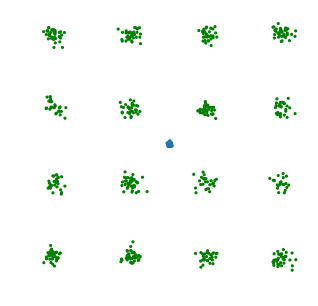

 10%|▉         | 2000/20001 [02:17<13:28, 22.27it/s]  

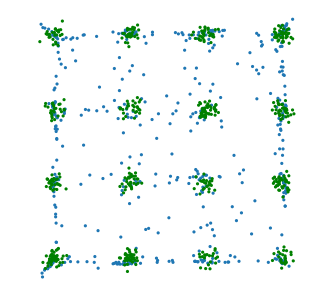

 20%|█▉        | 3998/20001 [04:35<11:59, 22.23it/s]  

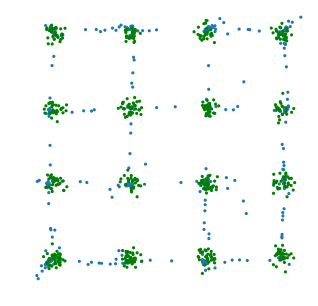

 30%|██▉       | 5999/20001 [06:54<10:19, 22.60it/s]  

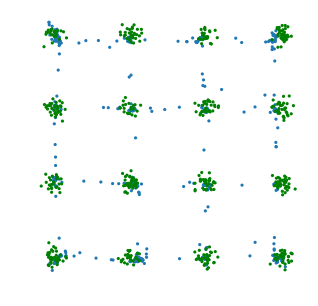

 40%|███▉      | 7998/20001 [09:14<09:11, 21.78it/s]  

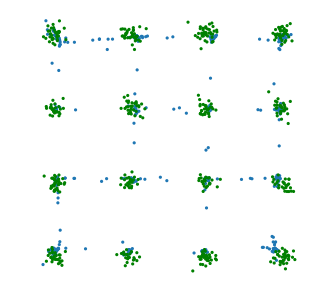

 50%|████▉     | 9999/20001 [11:36<07:33, 22.06it/s]  

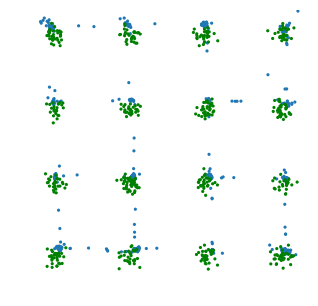

 60%|█████▉    | 12000/20001 [13:57<06:03, 22.01it/s]  

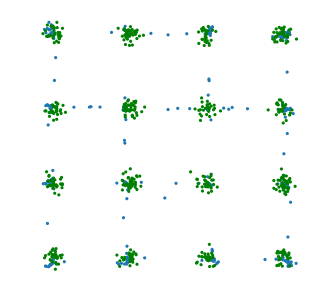

 70%|██████▉   | 13998/20001 [16:19<04:31, 22.13it/s]  

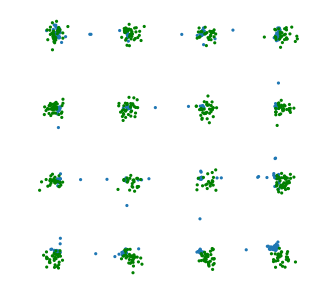

 80%|███████▉  | 15999/20001 [18:40<02:57, 22.60it/s]

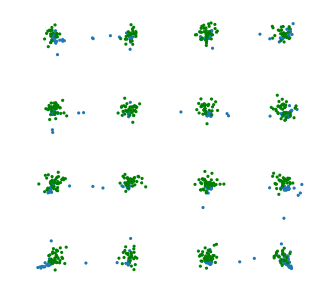

 90%|████████▉ | 17999/20001 [21:01<01:27, 22.84it/s]

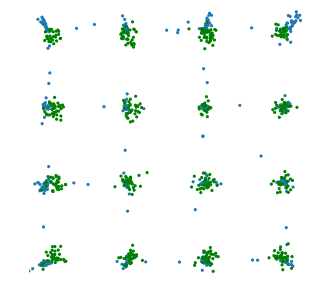

100%|█████████▉| 20000/20001 [23:19<00:00, 22.64it/s]

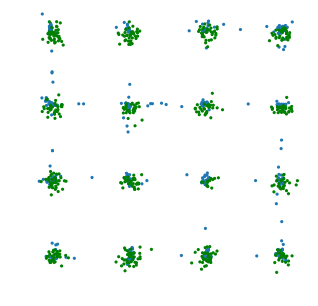

100%|██████████| 20001/20001 [23:24<00:00, 14.24it/s]


In [12]:
xmax = 3
fs = []
raw_frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
frame_every = params['frame_every']

nn_every = 200
y_ref = sess.run(data)
nn_dist = []
nn_kl =[]

for i in tqdm(range(params['max_iter']+1)):
    f, _ = sess.run([[loss], g_train_op])
    for j in range(params['CRITIC_ITERS']):
        _ = sess.run(d_train_op)
        if params['mode'] == 'wgan':
            _ = sess.run(clip_disc_weights)
    fs.append(f)
    if (i) % frame_every == 0:
        if params['optimizer'] == 'default_ema':
            np_samples.append(np.vstack([sess.run(samples_ema) for _ in range(n_batches_viz)]))
            xx, yy = sess.run([samples_ema, data])
        else:
            np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
            xx, yy = sess.run([samples, data])

        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        if params["data"]=="complex":
            plt.xlim([-0.2, 1.2])
            plt.ylim([-0.2, 1.2])
        else:
            plt.xlim([-5.5, 5.5])
            plt.ylim([-5.5, 5.5])
        axis('off')
        if params['generate_movie']:
            raw_frames.append(mplfig_to_npimage(fig))
        if (i) % viz_every == 0:
            show()
            
    if (i) % nn_every == 0:
        if params['optimizer'] == 'default_ema':
            x = np.vstack([sess.run(samples_ema) for _ in range(n_batches_viz)])
        else:
            x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
        l2nn = nn_l2_mean(x,y_ref)
        kl =estimate(x, y_ref,k=1)
        nn_dist.append(l2nn)
        nn_kl.append(kl)    

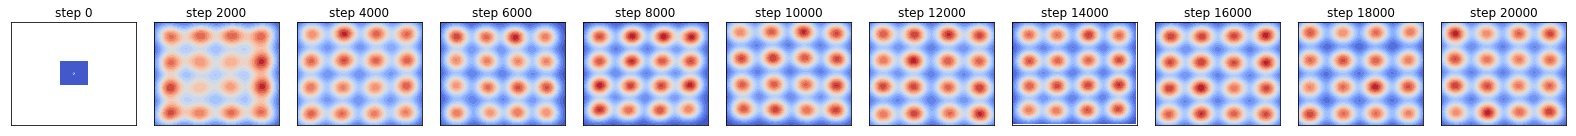

In [13]:
np_samples_ = np_samples[::1]
vizu_frames = []
cols = len(np_samples_)
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm', bw=.40, n_levels=20, clip=[[-6,6]]*2)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

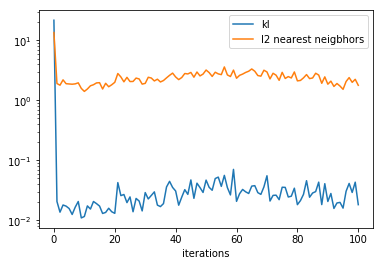

In [14]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [15]:
np.save('plot_{}_{}_kl'.format(params['mode'],params['optimizer']),nn_kl)
np.save('plot_{}_{}_nn'.format(params['mode'],params['optimizer']),nn_dist)

## Video maker

In [16]:
if params['generate_movie']:
    np_samples_ = np_samples[::1]
    vizu_frames = []
    cols = len(np_samples_)
    bg_color  = sns.color_palette('Greens', n_colors=256)[0]
    fig, ax = plt.subplots()
    for i, samps in enumerate(np_samples_):
        ax.clear()
        ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm', bw=.40, n_levels=20, clip=[[-6,6]]*2)

        xticks([]); yticks([])
        title('step %d'%(i*frame_every))
        if generate_movie:
            vizu_frames.append(mplfig_to_npimage(fig))
    
    # Generate movie
    
    raw_clip = mpy.ImageSequenceClip(raw_frames[::], fps=10)
    raw_clip.write_videofile("raw_optimizer_{}_{}_{}.webm".format(params['optimizer'], params['mode'], params['data']), audio=False)
    vizu_clip = mpy.ImageSequenceClip(vizu_frames[::], fps=10)
    vizu_clip.write_videofile("vizu_optimizer_{}_{}_{}.webm".format(params['optimizer'], params['mode'], params['data']), audio=False)